In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import XYZ_to_Lab, delta_E, XYZ_to_RGB, RGB_to_XYZ
from colour.models import RGB_COLOURSPACE_sRGB
import tifffile
import zarr
from colour_lib.utils.rawparser import RawDataParser
from colour_lib.utils.circlelib import *

In [2]:
global_dir = "/uftp/src/"
rw = RawDataParser(reference_basepath=f"{global_dir}calibration_data/")

In [3]:
def image_read(sector, g1, g2, g3):
    store = tifffile.imread(
        f"{global_dir}palettes/Calib_{sector}_{g1}_{g2}_{g3}_202402.tif", aszarr=True
    )
    zarr_pyramids = zarr.open(store, mode="r")
    image = np.array(zarr_pyramids[3]) / 255
    gammas = [(g1 / 10), (g2 / 10), (g3 / 10)]
    image_revert = apply_gammaCorr(image, gammas)
    return image_revert

In [4]:
def coords_read(sz):
    return pd.read_csv(f"{global_dir}saved_coords/manual/huron0224/{sz}um_coords.csv")

In [5]:
images = {"R1_111": image_read("R1", 10, 10, 10)}
rads = {
    "4150": 40,
    "1000": 10,
    "750": 6,
    "500": 4,
    "400": 4,
    "300": 2,
    "250": 2,
    "200": 1,
    "150": 1,
    "CA1000": 50,
}
coords = {
    "4150": coords_read(4150),
    "1000": coords_read(1000),
    "750": coords_read(750),
    "500": coords_read(500),
    "400": coords_read(400),
    "300": coords_read(300),
    "250": coords_read(250),
    "200": coords_read(200),
    "150": coords_read(150),
    "CA1000": coords_read("CA1000"),
}

<tifffile.TiffPage 6 @11318147692> missing data offset tag


In [6]:
list(coords.items())[0][1].shape[0]

24

In [7]:
def draw_circle_mask(image, coord, radius):
    mask_shape = image.shape
    coords_y, coords_x = np.ogrid[: mask_shape[0], : mask_shape[1]]
    circle_mask = np.zeros(mask_shape[:2], dtype=bool)
    for idx, centroids in coord.iterrows():
        centroid_y, centroid_x = centroids["Y"], centroids["X"]
        circle_mask = circle_mask | (
            (coords_y - centroid_y) ** 2 + (coords_x - centroid_x) ** 2 <= radius**2
        )

    plt.imshow(image)
    plt.imshow(circle_mask, alpha=0.5)

In [8]:
CA = calc_rectangle(images["R1_111"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangles(
    images["R1_111"],
    coords,
    rads,
    zones=["1000", "750", "500", "400", "300", "250", "200", "150"],
)

/home/gboykov/colour_project/src/colour_lib/circle_process/circlelib.py:66: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
slide_vals = calc_slide(CA, slide)
slide_vals[1]

array([ 0.        ,  0.15751158,  0.3848427 ])

In [10]:
from colour.models.rgb import RGB_COLOURSPACES, RGB_to_XYZ

SRGB_COLSPACE = RGB_COLOURSPACES["sRGB"]
SRGB_COLSPACE.cctf_encoding(slide_vals[1]) * 255

array([   0.        ,  110.52378999,  166.68991411])

In [11]:
RGB_to_XYZ(
    RGB=slide_vals,
    colourspace=SRGB_COLSPACE,
    illuminant=None,
    chromatic_adaptation_transform=None,
    apply_cctf_decoding=False,
)

array([[ 0.92091705,  0.97160646,  1.05229827],
       [ 0.12579025,  0.14043793,  0.38456837],
       [ 0.18410932,  0.15329275,  0.01988484],
       [ 0.22804235,  0.13679702,  0.14850182],
       [ 0.10631628,  0.17597541,  0.14549881],
       [ 0.57435428,  0.64696061,  0.09460418],
       [ 0.04065583,  0.02456704,  0.15517823],
       [ 0.05230174,  0.04173314,  0.06901198],
       [ 0.85799851,  0.90154229,  0.96430745],
       [ 0.60766369,  0.64222794,  0.70026822],
       [ 0.37339859,  0.39433953,  0.4450934 ],
       [ 0.22063718,  0.16601279,  0.02648141],
       [ 0.3586241 ,  0.33393191,  0.04555377],
       [ 0.46400885,  0.4917151 ,  0.07045462],
       [ 0.29988004,  0.40704639,  0.0798035 ],
       [ 0.17166513,  0.1787331 ,  0.20458631],
       [ 0.05651195,  0.05981363,  0.06118079],
       [ 0.01318717,  0.01268617,  0.0128499 ],
       [ 0.08020761,  0.06555349,  0.29436904],
       [ 0.26007261,  0.36390842,  0.56834886],
       [ 0.25234455,  0.23531387,  0.432

In [12]:
colour_arrays = {
    "exp_srgbs": slide_vals,
    "exp_xyz": RGB_to_XYZ(RGB=slide_vals, colourspace=SRGB_COLSPACE),  # correctted
    "ref_srgbs": rw.get_reference_srgbs(),
    "ref_xyz": rw.get_reference_d65(),
}

In [13]:
from colour_lib.regressors.PLSregressor import PLSRegressor
from colour_lib.regressors.LassoRegressor import LassoRegressor
from colour_lib.regressors.StackedRegressor import StackedRegressor
from colour_lib.regressors.ThinPlateSpline import TPSRegressor

In [14]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import linear_model
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor


class VoteRegressor:
    def __init__(self, train_data, reference_data, random_state=0.0, alpha=0.01):
        # base_models = [
        #     ("linear", linear_model.Lasso(alpha=alpha)),
        #     ("rf", PLSRegression(n_components=train_data.shape[-1])),
        # ]
        base_models = [
            ("linear", LinearRegression()),
            ("rf", RandomForestRegressor()),
            ("svr", SVR()),
        ]
        self.reg = MultiOutputRegressor(
            VotingRegressor(estimators=base_models), n_jobs=-1
        )
        self.reg.fit(train_data, reference_data)

    def predict(self, img):
        mod_img = img.copy()
        for i, strip in enumerate(mod_img):
            strip = self.reg.predict(strip)
            mod_img[i] = strip.copy()
        return mod_img

In [15]:
PLS_reg = PLSRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])
Lasso_reg = LassoRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"], 0.01)
Test_reg = VoteRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])

In [16]:
images["HS1 PLS reg"] = PLS_reg.predict(images["R1_111"])

In [17]:
images["HS1 Lasso reg"] = Lasso_reg.predict(images["R1_111"])

In [18]:
images["HS1 Test reg"] = Test_reg.predict(images["R1_111"])

In [19]:
CA = calc_rectangle(images["HS1 PLS reg"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangle(images["HS1 PLS reg"], coords["1000"], rads["1000"])
colour_arrays["PLS_reg_srgbs"] = calc_slide(CA, slide)
CA = calc_rectangle(images["HS1 Lasso reg"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangle(images["HS1 Lasso reg"], coords["1000"], rads["1000"])
colour_arrays["Lasso_reg_srgbs"] = calc_slide(CA, slide)
CA = calc_rectangle(images["HS1 Test reg"], coords["CA1000"], rads["CA1000"])
slide = calc_rectangle(images["HS1 Test reg"], coords["1000"], rads["1000"])
colour_arrays["Test_reg_srgbs"] = calc_slide(CA, slide)

/home/gboykov/colour_project/src/colour_lib/circle_process/circlelib.py:13: RuntimeWarning: invalid value encountered in power
  ret[i] = _transposed[i] ** (gamma)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0343135869794..1.00207246998].


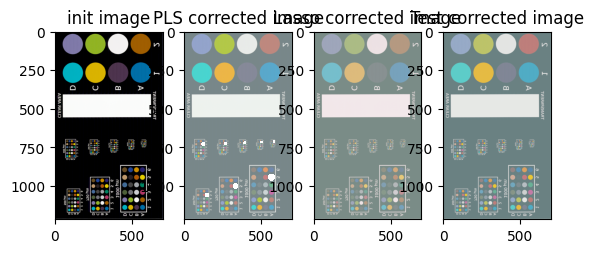

In [20]:
name_list = [
    ["R1_111", "init image"],
    ["HS1 PLS reg", "PLS corrected image"],
    ["HS1 Lasso reg", "Lasso corrected image"],
    ["HS1 Test reg", "Test corrected image"],
]

f, axarr = plt.subplots(1, 4)
for i, vector in enumerate(name_list):
    axarr[i].imshow(apply_gammaCorr(images[vector[0]], [1 / 2.2, 1 / 2.2, 1 / 2.2]))
    axarr[i].set_title(vector[1])

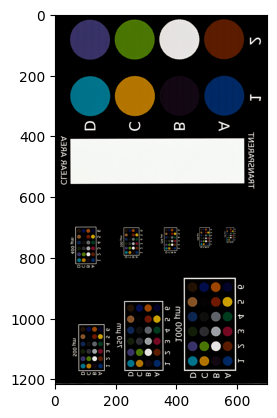

In [21]:
plt.imshow(images["R1_111"])

In [22]:
np.mean(
    calculate_delta_E(
        RGB_to_XYZ(RGB=colour_arrays["exp_srgbs"], colourspace=SRGB_COLSPACE),
        colour_arrays["ref_xyz"],
    )
)

11.120379182757549

In [23]:
np.mean(
    calculate_delta_E(
        RGB_to_XYZ(RGB=colour_arrays["PLS_reg_srgbs"], colourspace=SRGB_COLSPACE),
        colour_arrays["ref_xyz"],
    )
)

20.402579581389592

In [24]:
np.mean(
    calculate_delta_E(
        RGB_to_XYZ(RGB=colour_arrays["Lasso_reg_srgbs"], colourspace=SRGB_COLSPACE),
        colour_arrays["ref_xyz"],
    )
)

23.601964032159643

In [25]:
np.mean(
    calculate_delta_E(
        RGB_to_XYZ(RGB=colour_arrays["Test_reg_srgbs"], colourspace=SRGB_COLSPACE),
        colour_arrays["ref_xyz"],
    )
)

20.253046807400686

In [26]:
calculate_delta_E(
    RGB_to_XYZ(RGB=colour_arrays["exp_srgbs"], colourspace=SRGB_COLSPACE),
    colour_arrays["ref_xyz"],
)

array([[  8.643969  ],
       [ 11.3274873 ],
       [ 28.59727777],
       [  8.19734142],
       [  7.98124241],
       [ 17.33729015],
       [ 11.14989666],
       [  5.90273458],
       [  8.92846133],
       [  9.46986223],
       [  8.84749177],
       [ 26.26738667],
       [ 19.01126427],
       [ 16.69441927],
       [  8.28950651],
       [  8.11425392],
       [  5.44350165],
       [ 10.20741705],
       [  3.64142144],
       [  8.83374515],
       [  9.5272674 ],
       [  1.86182183],
       [  6.62957174],
       [ 14.09266798],
       [ 13.01218007]])

In [27]:
calculate_delta_E(
    RGB_to_XYZ(RGB=colour_arrays["PLS_reg_srgbs"], colourspace=SRGB_COLSPACE),
    colour_arrays["ref_xyz"],
)

array([[  6.28782341],
       [ 26.28323552],
       [ 32.81769358],
       [ 19.08509903],
       [ 21.30139232],
       [ 13.11416758],
       [ 30.56425386],
       [ 31.2042196 ],
       [  7.07812307],
       [  9.52167512],
       [ 12.79925857],
       [ 24.43743614],
       [ 18.58216014],
       [ 14.0533136 ],
       [ 12.47062454],
       [ 20.20691345],
       [ 27.80027217],
       [ 34.02258875],
       [ 27.15199208],
       [ 13.67000032],
       [ 17.82715546],
       [ 25.70780702],
       [ 21.67536935],
       [ 13.88247652],
       [ 28.51943832]])

In [28]:
calculate_delta_E(
    RGB_to_XYZ(RGB=colour_arrays["Lasso_reg_srgbs"], colourspace=SRGB_COLSPACE),
    colour_arrays["ref_xyz"],
)

array([[  9.83187104],
       [ 27.07524041],
       [ 40.77933499],
       [ 29.94980639],
       [ 23.1195567 ],
       [ 17.43883899],
       [ 34.03626908],
       [ 36.48459426],
       [  9.91648949],
       [ 10.85621934],
       [ 12.84205865],
       [ 34.06002539],
       [ 23.53703373],
       [ 18.15708578],
       [ 15.27007484],
       [ 20.48244866],
       [ 29.33785624],
       [ 35.99581136],
       [ 28.99528033],
       [ 14.23061402],
       [ 19.40275297],
       [ 26.38084928],
       [ 21.88719455],
       [ 16.82357743],
       [ 33.15821687]])

In [29]:
calculate_delta_E(
    RGB_to_XYZ(RGB=colour_arrays["Test_reg_srgbs"], colourspace=SRGB_COLSPACE),
    colour_arrays["ref_xyz"],
)

array([[  4.52553485],
       [ 26.90696454],
       [ 29.27364159],
       [ 21.7506817 ],
       [ 21.66355113],
       [ 13.52117005],
       [ 29.60832793],
       [ 29.91960359],
       [  5.82521866],
       [  9.07105588],
       [ 14.06422214],
       [ 22.86472852],
       [ 20.67134153],
       [ 16.31427422],
       [ 12.66433924],
       [ 20.86489497],
       [ 26.41162985],
       [ 31.7982417 ],
       [ 28.26099909],
       [ 12.24983634],
       [ 19.87911748],
       [ 24.80009531],
       [ 22.95645405],
       [ 14.84848725],
       [ 25.6117586 ]])